In [2]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [3]:

AAPL = yf.download(
        "AAPL",                    # Ticker symbol
        start="2018-01-01",       # Start date  
        end="2025-07-20",         # End date (recent)
        progress=False,           # Don't show progress bar
        auto_adjust=True          # Adjust for splits/dividends
    )
MSFT = yf.download(
        "MSFT",                    # Ticker symbol
        start="2018-01-01",       # Start date  
        end="2025-07-20",         # End date (recent)
        progress=False,           # Don't show progress bar
        auto_adjust=True          # Adjust for splits/dividends
    )
TSLA = yf.download(
        "TSLA",                    # Ticker symbol
        start="2018-01-01",       # Start date  
        end="2025-07-20",         # End date (recent)
        progress=False,           # Don't show progress bar
        auto_adjust=True          # Adjust for splits/dividends
    )
NVDA = yf.download(
        "NVDA",                    # Ticker symbol
        start="2018-01-01",       # Start date  
        end="2025-07-20",         # End date (recent)
        progress=False,           # Don't show progress bar
        auto_adjust=True          # Adjust for splits/dividends
    )


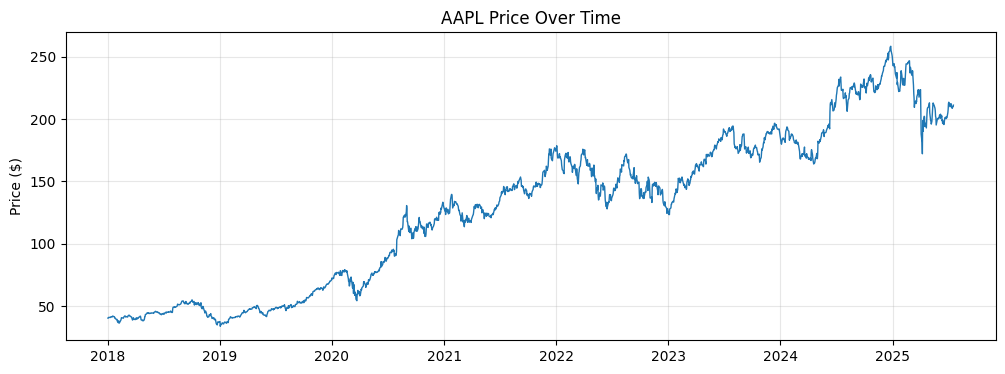

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(AAPL.index, AAPL['Close'], linewidth=1)
plt.title("AAPL Price Over Time")
plt.ylabel("Price ($)")
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
import pandas as pd
import numpy as np

def feature_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df['Next_Return'] = df['Close'].pct_change().shift(-1)

    df['MA5'] = df['Close'].rolling(window=5).mean()

    close_df = df['Close']              
    close = close_df.squeeze()         

    ma5 = close.rolling(window=5).mean()
    std5 = close.rolling(window=5).std()

    df['MA5'] = ma5
    df['Z5']  = (close - ma5) / std5   

    df['RSI14'] = compute_rsi(df['Close'], window=14)

    df['Vol10'] = df['Close'].pct_change().rolling(window=10).std()

    df_clean = df.dropna()
    return df_clean

def compute_rsi(series: pd.Series, window: int) -> pd.Series:
    delta    = series.diff()
    gain     = delta.clip(lower=0)
    loss     = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs       = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

AAPL_clean = feature_engineer(AAPL)
NVDA_clean = feature_engineer(NVDA)
TSLA_clean = feature_engineer(TSLA)
MSFT_clean = feature_engineer(MSFT)

AAPL_clean.columns = [col[0] if isinstance(col, tuple) else col for col in AAPL_clean.columns]
NVDA_clean.columns = [col[0] if isinstance(col, tuple) else col for col in NVDA_clean.columns]
TSLA_clean.columns = [col[0] if isinstance(col, tuple) else col for col in TSLA_clean.columns]
MSFT_clean.columns = [col[0] if isinstance(col, tuple) else col for col in MSFT_clean.columns]


In [6]:
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

post_train = {}

for stock_name, stock_df in [('AAPL', AAPL_clean), ('NVDA', NVDA_clean), ('TSLA', TSLA_clean), ('MSFT', MSFT_clean)]:
    total_days = len(stock_df)
    train_end = int(total_days * 0.80)

    train_data = stock_df.iloc[:train_end]
    val_data = stock_df.iloc[train_end:total_days]
    
    features = ['MA5','Z5','RSI14','Vol10']
    target = 'Next_Return'

    def ridge_alpha(alpha):
        ridge=Ridge(alpha=alpha)
        ridge.fit(train_data[features],train_data[target])
        pred = ridge.predict(val_data[features])
        return mean_squared_error(val_data[target],pred)
    
    optimizer = BayesianOptimization(
        f=ridge_alpha,
        pbounds={'alpha':(0.001, 100.0)},
        verbose=1,
        random_state=42
    )

    optimizer.maximize(init_points=5, n_iter=25)

    best_alpha = optimizer.max['params']['alpha']
    best_mse = -optimizer.max['target']

    final_model = Ridge(alpha=best_alpha)
    final_model.fit(train_data[features],train_data[target])
    
    post_train[stock_name] = {
        'best_alpha':best_alpha,
        'best_mse':best_mse,
        'model':final_model
    }
    

|   iter    |  target   |   alpha   |
-------------------------------------
| 5         | 0.0003500 | 15.602708 |
| 6         | 0.0003507 | 0.0021634 |
| 23        | 0.0003507 | 0.0019127 |
|   iter    |  target   |   alpha   |
-------------------------------------
| 5         | 0.0012283 | 15.602708 |
| 20        | 0.0012283 | 14.197313 |
| 23        | 0.0012283 | 13.134632 |
| 27        | 0.0012283 | 12.748965 |
|   iter    |  target   |   alpha   |
-------------------------------------
| 2         | 0.0018505 | 95.071479 |
| 8         | 0.0018505 | 99.990097 |
| 10        | 0.0018505 | 99.997214 |
| 14        | 0.0018505 | 99.999204 |
|   iter    |  target   |   alpha   |
-------------------------------------
| 5         | 0.0002192 | 15.602708 |
| 6         | 0.0002193 | 0.0021634 |


1. Threshold Strategy
2. Stock-Specific vs Universal:
3. Signal Strength:
4. Time Horizon:
5. Risk Filters: